In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import regionmask

In [7]:
monthly_forecast=xr.Dataset()
da1 = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\POWER_Regional_monthly_1997_2020.nc"
da2 = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\POWER_Regional_monthly_1997_2020_south.nc"
file_paths_list =[da1,da2]

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)],compat='no_conflicts')

states_gdf = gpd.read_file(r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\som_adm_ocha_itos_20230308_shp\som_admbnda_adm1_ocha_20230308.shp") 

In [8]:
regions_nev = states_gdf[states_gdf.ADM1_EN.isin(states_gdf["ADM1_EN"])]
region_mask = regionmask.mask_3D_geopandas(regions_nev,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

In [9]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(regions_nev)

In [10]:
monthly_forecast

<xarray.Dataset>
Dimensions:      (time: 312, lon: 21, lat: 28)
Coordinates:
  * time         (time) float64 1.997e+05 1.997e+05 ... 2.02e+05 2.02e+05
  * lon          (lon) float32 41.25 41.75 42.25 42.75 ... 50.25 50.75 51.25
  * lat          (lat) float32 -1.75 -1.25 -0.75 -0.25 ... 10.75 11.25 11.75
Data variables:
    PRECTOTCORR  (time, lat, lon) float32 dask.array<chunksize=(312, 28, 21), meta=np.ndarray>
    T2M_MAX      (time, lat, lon) float32 dask.array<chunksize=(312, 28, 21), meta=np.ndarray>

In [11]:
summary = monthly_forecast.where(region_mask).groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [12]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower Juba',
9   :   'Lower Shabelle',
10  :      'Middle Juba',
11   : 'Middle Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi Galbeed'}

In [13]:
summary['region'] = summary['region'].replace(replacement_dict)

In [14]:
# merge states_gdf with summary1 based on column 'region' even if some regions are missing
start_date = 199701.0
summary1 = summary[summary['time']==start_date]
summary1['region'] = summary1['region'].replace(replacement_dict)
merged = states_gdf.merge(summary1, left_on='ADM1_EN', right_on='region', how='outer')

C:\Users\PcLaptop\AppData\Local\Temp\ipykernel_3336\564505865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary1['region'] = summary1['region'].replace(replacement_dict)


In [15]:
one_month_region = monthly_forecast["T2M_MAX"].sel(
    time=slice(start_date, start_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

one_month_region_p = monthly_forecast["PRECTOTCORR"].sel(
    time=slice(start_date, start_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

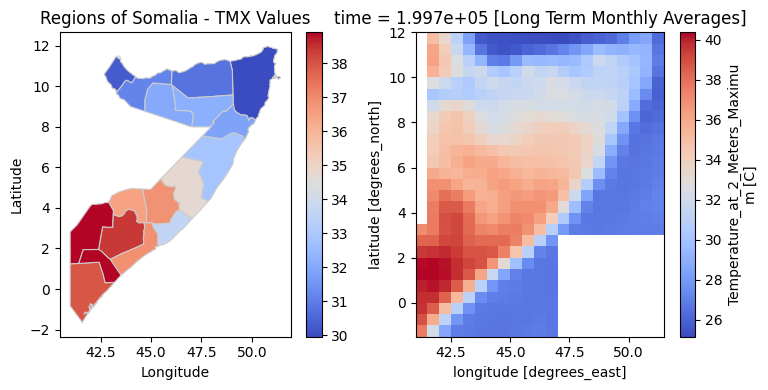

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first map - Regions of Somalia colored by tmx
merged.plot(column='T2M_MAX', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Regions of Somalia - TMX Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
one_month_region.plot(ax=ax2, cmap='coolwarm')

plt.tight_layout()
plt.show()

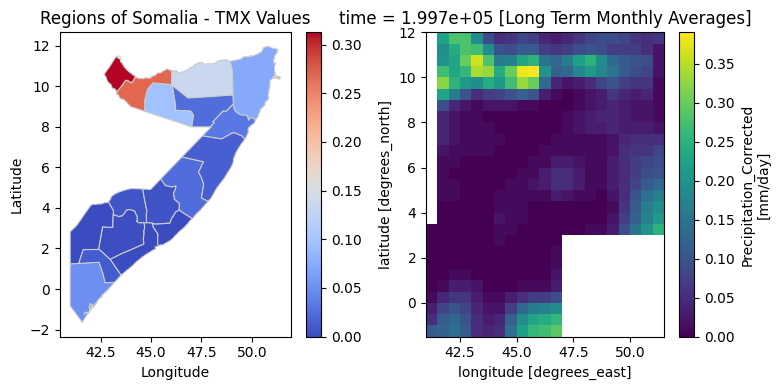

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first map - Regions of Somalia colored by tmx
merged.plot(column='PRECTOTCORR', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Regions of Somalia - TMX Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
one_month_region_p.plot(ax=ax2)

plt.tight_layout()
plt.show()

In [18]:
#summary.to_csv('temp_pre_new.csv', index=False)